# Formative 1 - Sound Clustering

## Import Required Libraries

We begin by importing all necessary libraries for audio processing, feature extraction, visualization, dimensionality reduction, and clustering.


In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

## Inspect Uploaded Files and Extract Audio Dataset

We check if the uploaded ZIP file exists and extract its contents to a target directory. The ZIP is assumed to contain `.wav` files of spoken digits.


In [2]:
import os
os.listdir("/content")

['.config', 'unlabelled_sounds.zip', 'sample_data']

In [3]:
!file /content/unlabelled_sounds.zip

/content/unlabelled_sounds.zip: Zip archive data, at least v2.0 to extract, compression method=store


In [4]:
!unzip -o /content/unlabelled_sounds.zip -d /content/sound_data

Archive:  /content/unlabelled_sounds.zip
   creating: /content/sound_data/unlabelled_sounds/
  inflating: /content/sound_data/unlabelled_sounds/3.wav  
  inflating: /content/sound_data/unlabelled_sounds/4.wav  
  inflating: /content/sound_data/unlabelled_sounds/10.wav  
  inflating: /content/sound_data/unlabelled_sounds/12.wav  
  inflating: /content/sound_data/unlabelled_sounds/13.wav  
  inflating: /content/sound_data/unlabelled_sounds/16.wav  
  inflating: /content/sound_data/unlabelled_sounds/23.wav  
  inflating: /content/sound_data/unlabelled_sounds/24.wav  
  inflating: /content/sound_data/unlabelled_sounds/32.wav  
  inflating: /content/sound_data/unlabelled_sounds/33.wav  
  inflating: /content/sound_data/unlabelled_sounds/37.wav  
  inflating: /content/sound_data/unlabelled_sounds/41.wav  
  inflating: /content/sound_data/unlabelled_sounds/45.wav  
  inflating: /content/sound_data/unlabelled_sounds/48.wav  
  inflating: /content/sound_data/unlabelled_sounds/49.wav  
  inflati

## Extract Mel Spectrogram Features

For each `.wav` file, we compute the Mel spectrogram and reduce it to a fixed-length feature vector by averaging over the time dimension.


In [5]:
# Load all audio files and extract Mel Spectrogram features
def extract_features(folder_path):
    features = []
    filenames = []
    for file in os.listdir(folder_path):
        if file.endswith('.wav'):
            file_path = os.path.join(folder_path, file)
            y, sr = librosa.load(file_path, sr=None)
            mel = librosa.feature.melspectrogram(y=y, sr=sr)
            mel_db = librosa.power_to_db(mel, ref=np.max)
            mel_mean = np.mean(mel_db, axis=1)  # Reduce time dimension
            features.append(mel_mean)
            filenames.append(file)
    return np.array(features), filenames

folder_path = "/content/sound_data/unlabelled_sounds"
X, filenames = extract_features(folder_path)
X = StandardScaler().fit_transform(X)

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1547
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2035
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1943
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2045
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1634
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1988
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py

## Visualize Raw Features Using Pairplot

To understand the distribution of raw features, we visualize the first 5 dimensions using a pairplot.


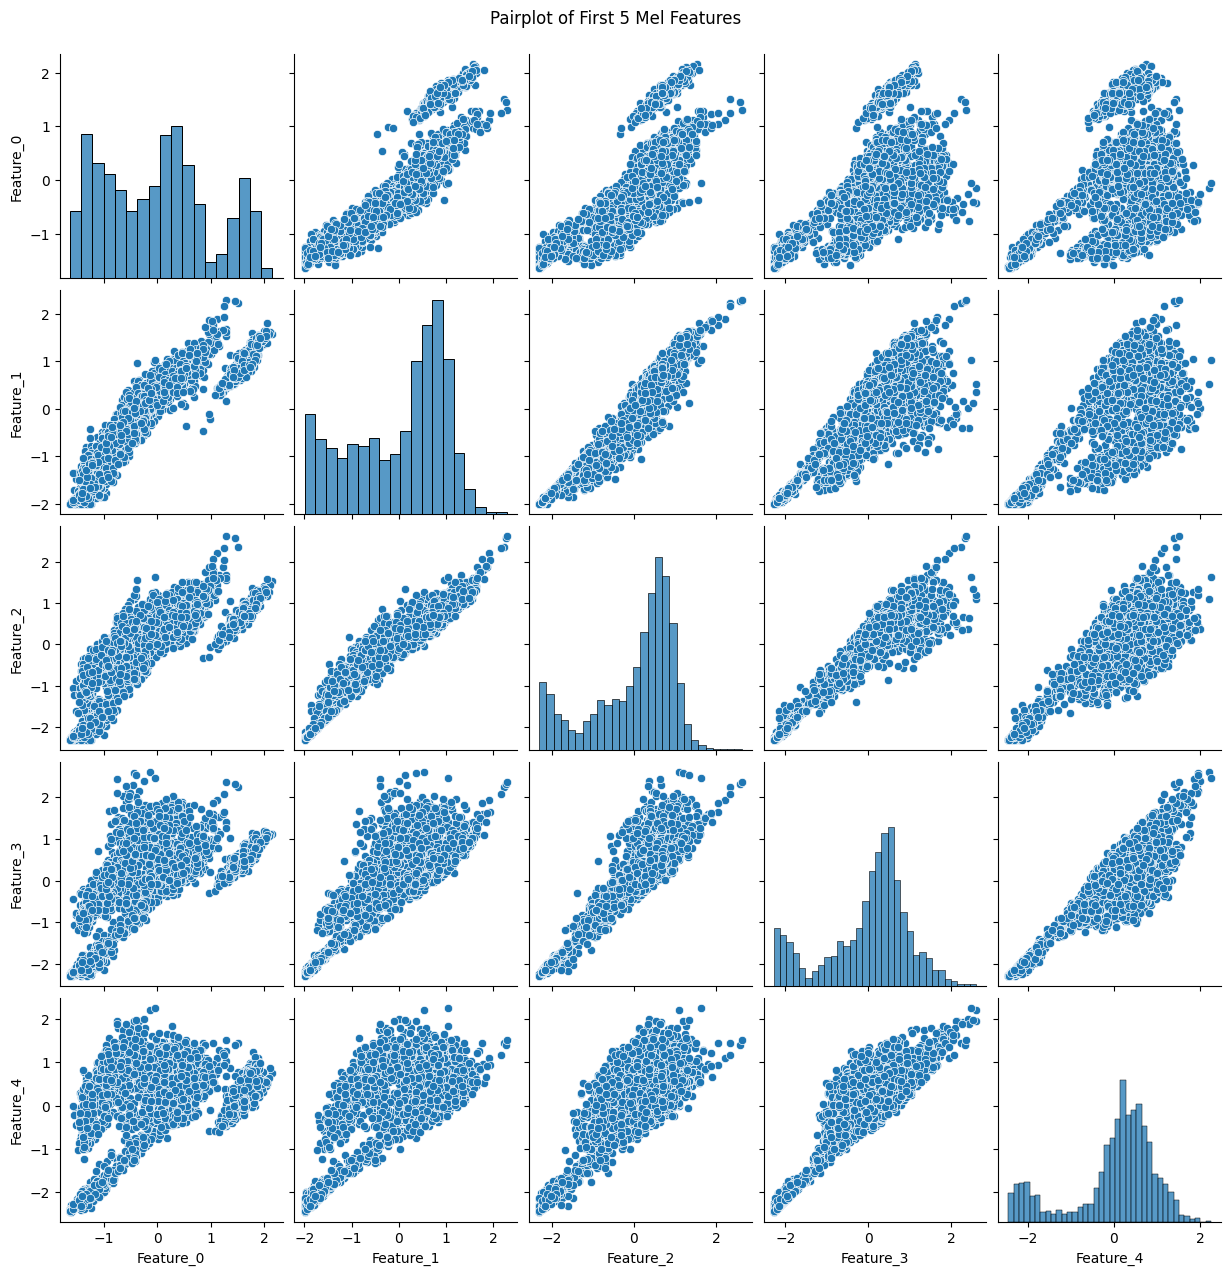

In [6]:
# Attempting pairplot or scatterplot
import pandas as pd

df = pd.DataFrame(X[:, :5], columns=[f"Feature_{i}" for i in range(5)])
sns.pairplot(df)
plt.suptitle("Pairplot of First 5 Mel Features", y=1.02)
plt.show()

## Why is Dimensionality Reduction Important?

As seen in the pairplot of the first 5 Mel spectrogram features, the data points are densely distributed with overlapping patterns. There are no clearly defined clusters or visual boundaries between different digit pronunciations. This highlights a limitation of raw feature space in high-dimensional data — the true structure is not easily observable. Dimensionality reduction techniques like PCA and t-SNE are needed to project the data into a more interpretable space where meaningful clusters may emerge.


## Dimensionality Reduction with PCA and t-SNE

We reduce the dataset to 3 dimensions using both PCA and t-SNE to compare their ability to reveal potential clusters.


In [7]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)


In [8]:
# t-SNE
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

## PCA vs t-SNE: Cluster Separability

In the 3D plots, t-SNE produced more visually distinct and tighter clusters than PCA. While PCA retained the most variance linearly, it failed to create strong visual separation between samples that likely represent different spoken digits. In contrast, t-SNE captured non-linear structures in the data, revealing clearer cluster boundaries. This suggests that t-SNE is more effective for uncovering hidden patterns in speech data like digit pronunciations, which are often non-linearly separable.


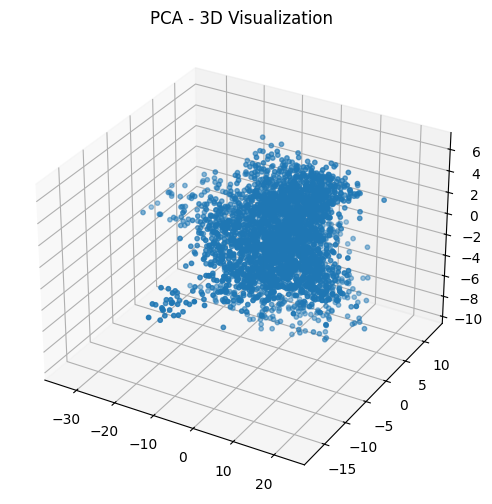

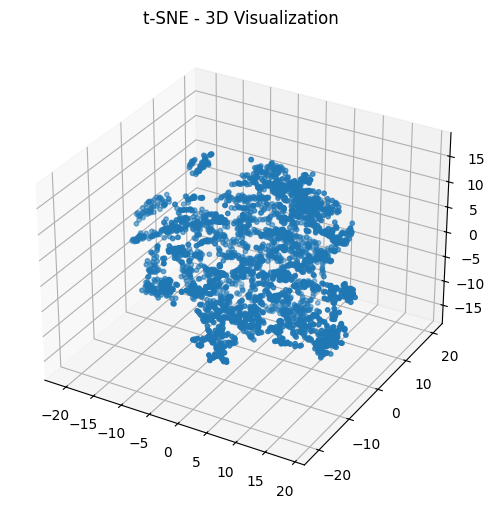

In [9]:
# 3D Plots
def plot_3d(data, title):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:,0], data[:,1], data[:,2], s=10)
    ax.set_title(title)
    plt.show()

plot_3d(X_pca, "PCA - 3D Visualization")
plot_3d(X_tsne, "t-SNE - 3D Visualization")

## Apply K-Means and DBSCAN Clustering

We cluster the reduced feature set using two algorithms: K-Means and DBSCAN. K-Means requires selecting the number of clusters, which we optimize using the elbow method and silhouette score.


In [36]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

# KMeans with Elbow and Silhouette
inertias = []
sil_scores = []
k_range = range(2, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X, kmeans.labels_))

In [33]:
n_clusters = len(set(kmeans_labels))
print(f"n_clusters = {n_clusters}")

n_clusters = 10


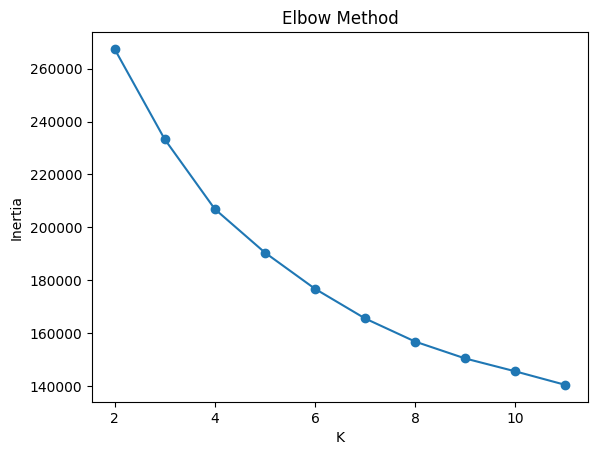

In [31]:
# Plot Elbow
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

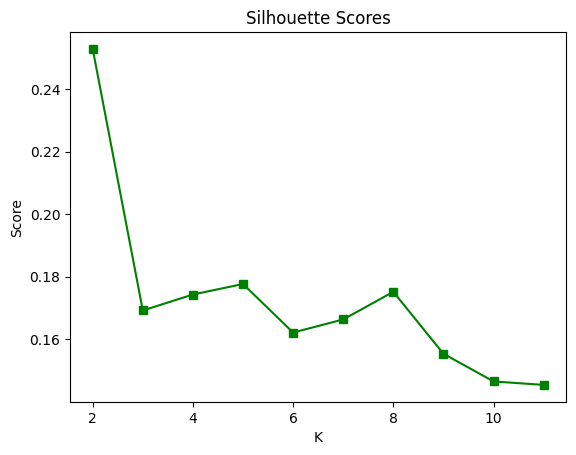

In [13]:
# Plot Silhouette
plt.plot(k_range, sil_scores, marker='s', color='green')
plt.title('Silhouette Scores')
plt.xlabel('K')
plt.ylabel('Score')
plt.show()

In [37]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

In [38]:
# DBSCAN
dbscan = DBSCAN(eps=5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

## Evaluate KMeans and DBSCAN Clustering

We use silhouette score and Davies-Bouldin index to compare clustering compactness and separation.


In [39]:
def evaluate_clustering(X, labels, name):
    sil = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    print(f"{name} → Silhouette: {sil:.3f}, DB Index: {db:.3f}")

In [40]:
evaluate_clustering(X, kmeans_labels, "K-Means")

K-Means → Silhouette: 0.147, DB Index: 1.727


In [41]:
evaluate_clustering(X, dbscan_labels, "DBSCAN")

DBSCAN → Silhouette: -0.220, DB Index: 1.736


## Visualize Clustering Results in t-SNE Space

We compare the cluster assignments produced by K-Means and DBSCAN using a 2D t-SNE scatterplot.


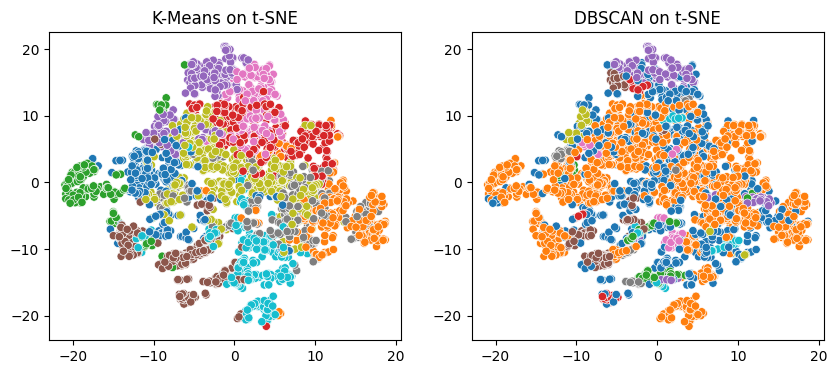

In [42]:
# Visual comparison (t-SNE)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=kmeans_labels, palette='tab10', legend=None)
plt.title("K-Means on t-SNE")
plt.subplot(1,2,2)
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=dbscan_labels, palette='tab10', legend=None)
plt.title("DBSCAN on t-SNE")
plt.show()

### Clustering Evaluation Summary

K-Means produced more compact and well-separated clusters compared to DBSCAN, as seen in both silhouette and Davies-Bouldin scores. The visual t-SNE plots confirmed this by showing clearer groupings with K-Means. DBSCAN struggled with inconsistent densities, labeling many points as noise. Dimensionality reduction using t-SNE made these differences more visible and helped interpret the results effectively.
